In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

<h3>
Reading data
</h3>
<p>
Reading our data using pandas library with read_csv and read_excel functions.
</p>
<p>
Since some of our data files(LF, EAF & CCM) are big we read it in independent cells in case if an error occurs it doesn't force us to read all of them again.
</p>

In [2]:
slab_original = pd.read_csv('data/slab.csv', sep=";")
defect_original = pd.read_excel('data/defect.xlsx')
heat_original = pd.read_excel('data/heat.xlsx')
process_original = pd.read_csv('data/process.csv', sep=";")

In [4]:
LF_original = pd.read_excel('data/LF.xlsx')

In [5]:
EAF_original = pd.read_excel('data/eaf.xlsx')

In [6]:
CCM_original = pd.read_excel('data/ccm.xlsx')

<p>
Since we'll manipulate these dataframes re-reading the original in case of an error or mistake takes lots of time. So we make a copy of them and work with copies. If an error occurs we simply just re-run the cell below:
</p>

In [7]:
slab = slab_original
defect = defect_original
heat = heat_original
process = process_original 
CCM = CCM_original
EAF = EAF_original
LF = LF_original

<h3>
Finding classes
</h3>
<p>
Since we'll solve this problem as a classification problem we need to find classes for slabs in our raw data. The defect tables which indicates the errors related to each slab can help us to label our data.
</p>
<p>
We figured using COD_CATG_DEF_ASDEF attribute to faulty slabs is not enough since a slab might have more than 1 error category at the same time but different ITMDF_COD_ITM_ITMDF. So we chose the pair of COD_CATG_DEF_ASDEF & ITMDF_COD_ITM_ITMDF as our fault labels.
</p>
<p>
Since there a large number of classes, we only select ones which cover more than 1% of faulty slabs to remove classes that cover an exteremly small number of samples in compare with tottal number of samples.
</p>
<p>
You can manipulate this coverage limit by chaning the <i>min_coverage</i> variable in cell below.
</p>

In [8]:
slab_defect_merged = pd.merge(slab, defect, how="left", left_on='PRODUCT_ID', right_on='PRODT_PRODUCT_ID')
slab_groups = slab_defect_merged.groupby(['ITMDF_COD_ITM_ITMDF','COD_CATG_DEF_ASDEF']).size().reset_index()
slab_groups = slab_groups.rename(columns={0: "SAMPLES_NO"})
sum_all = np.sum(slab_groups["SAMPLES_NO"])
slab_groups["COVERAGE_PERC"] = np.round(((slab_groups["SAMPLES_NO"] * 100) / sum_all), 2)
print(f"There are a total of {len(slab_groups)} different classes.")

There are a total of 113 different classes.


<p>
It is shown in the figure of next cell that many classes only cover a small number of faults.
</p>

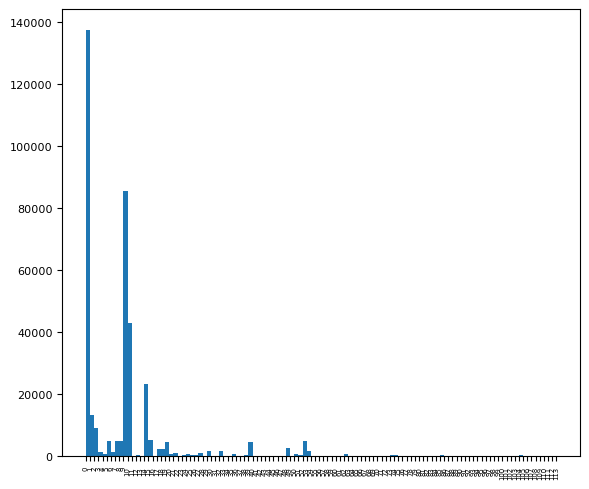

In [9]:
faults = slab_defect_merged["ITMDF_COD_ITM_ITMDF"] + "/" + slab_defect_merged["COD_CATG_DEF_ASDEF"]
faults = faults.astype(str)
names = pd.factorize(faults.unique(), na_sentinel=None)
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(np.array(faults), bins=names[1])
# ax.set_xticklabels(names[0], rotation=90, rotation_mode="anchor", ha="right", fontsize=5)
ax.xaxis.set_major_locator(mticker.FixedLocator(names[0]))
ax.xaxis.set_major_formatter(mticker.FixedFormatter(names[0]))
ax.tick_params(axis='x', labelsize=5, rotation=90)
ax.tick_params(axis='y', labelsize=8)
plt.axis('tight')
fig.tight_layout()
plt.show() 

In [10]:
min_coverage = 1
filtered_by_coverage = slab_groups.loc[slab_groups["COVERAGE_PERC"] > min_coverage]
print(filtered_by_coverage)
coverage = np.sum(filtered_by_coverage["COVERAGE_PERC"])
print(f"{len(filtered_by_coverage)} claases above covers {np.round(coverage, 2)}% of faulty slabs")

    ITMDF_COD_ITM_ITMDF COD_CATG_DEF_ASDEF  SAMPLES_NO  COVERAGE_PERC
9       TEC/DEFECT/1002     HOT INSPECTION        4894           1.32
12      TEC/DEFECT/1005     HOT INSPECTION        4450           1.20
35        TEC/DEFECT/48    COLD INSPECTION        4493           1.21
36        TEC/DEFECT/49    COLD INSPECTION       13177           3.55
47       TEC/DEFECT/900   CAST ABNORMALITY      137405          36.99
59       TEC/DEFECT/920   CAST ABNORMALITY       85702          23.07
61       TEC/DEFECT/922   CAST ABNORMALITY        4773           1.28
62       TEC/DEFECT/923   CAST ABNORMALITY        4750           1.28
63       TEC/DEFECT/924   CAST ABNORMALITY        4767           1.28
64       TEC/DEFECT/925   CAST ABNORMALITY       23266           6.26
65       TEC/DEFECT/926   CAST ABNORMALITY       42929          11.56
106      TEC/DEFECT/988     HOT INSPECTION        9198           2.48
107      TEC/DEFECT/989     HOT INSPECTION        5276           1.42
13 claases above cov

<h3>
Selecting samples
</h3>
<p>
Since the number of our samples is already very large and it's eventually will get bigger later when we join them with other tables(dataframes), It's better to choose an smaller number of samples from each class that we chose above.
</p>
<p>
There is a number of slabs which doesn't have any corresponding records in defect table we label them as perfect slabs and choose samples from this class too.
</p>
<p>
We choose 1000 samples from classes which cover more than 10% of slab faults and for the rest we choose [100 * Coverage_pertentage] number of slabs. This way the balance between the number of samples from each class is also observed. If We choose too much from a class later in classification it may cause the model to predict most of the samples to that class.
</p>

In [12]:

df_0 = slab_defect_merged[slab_defect_merged['COD_CATG_DEF_ASDEF'].isnull()]
df_0.insert(0, "LABEL", 0)
df_0 = df_0.sample(250)
dfs = [df_0]
index_counter = 1
for i, row in (filtered_by_coverage.iterrows()):
    temp = slab_defect_merged[(slab_defect_merged['ITMDF_COD_ITM_ITMDF'] == row['ITMDF_COD_ITM_ITMDF']) &\
                (slab_defect_merged['COD_CATG_DEF_ASDEF'] == row['COD_CATG_DEF_ASDEF'])]
    temp.insert(0, "LABEL", index_counter)
    sample_size = int(row['COVERAGE_PERC'] * 100) if (row['COVERAGE_PERC'] < 10) else 1000
    dfs.append(temp.sample(sample_size))
    index_counter += 1

print(f"The total number of classes including perfect slabs is now: {len(dfs)}")

The total number of classes including perfect slabs is now: 14


<h3>Cleaning dataframes</h3>
<p>
Before joining slabs with other tables, we drop some attributes that we deemed uselss for varoius reasons like including too much nan values & etc from dataframes. We also removed the records which include nan values.
</p>

In [13]:
# removing VAL_ITM_A_PRITM (too many nans)
CCM = CCM.drop('VAL_ITM_A_PRITM', axis=1)
EAF = EAF.drop('VAL_ITM_A_PRITM', axis=1)
LF = LF.drop('VAL_ITM_A_PRITM', axis=1)
LF = LF.dropna()
EAF = EAF.dropna()
CCM = CCM.dropna()

<p>
There are attributes in the dataframes resulted from joining slabs and defect dataframes which is not going to be usefull (like IDs & some information codes). These attributes are also removed from our samples.
</p>

In [14]:
samples = pd.concat(dfs)
samples = samples.drop('PRODT_PRODUCT_ID_y', axis=1)
samples = samples.drop('PROD_STATUS_DEFECT_ID', axis=1)
samples = samples.drop('ASITM_AREA_STRUC_ITEM_ID', axis=1)
samples = samples.drop('ITMDF_COD_ITM_ITMDF', axis=1)
slabs = samples.drop('COD_CATG_DEF_ASDEF', axis=1)

In [15]:
slabs = slabs.dropna()
heat = heat.dropna()
process = process.dropna()

<h3>Merging dataframes</h3>
<p>
We merge our dataframes using a left outer join. Since process has 1..n relationship CCM, LF & AEF entities we join them seperatly and concat them with each other.
</p>

In [16]:
slabs_heat_joined = pd.merge(slabs, heat, how="left", left_on='PRODT_PRODUCT_ID_x', right_on='PRODUCT_ID')
samples = slabs_heat_joined.dropna()

In [17]:
samples_process_joined = pd.merge(samples, process, how="left", left_on='PRODT_PRODUCT_ID_x', right_on='PRODT_PRODUCT_ID')
samples_process_joined = samples_process_joined[samples_process_joined['PRODT_PRODUCT_ID_x'].notna()]

In [18]:
ccm_process = pd.merge(samples_process_joined, CCM, how="left", left_on='PROCESS_RESULT_ID', right_on='PCRSL_PROCESS_RESULT_ID')
lf_process = pd.merge(samples_process_joined, LF, how="left", left_on='PROCESS_RESULT_ID', right_on='PCRSL_PROCESS_RESULT_ID')
eaf_process = pd.merge(samples_process_joined, EAF, how="left", left_on='PROCESS_RESULT_ID', right_on='PCRSL_PROCESS_RESULT_ID')

In [19]:
all_data_joined = pd.concat([ccm_process, lf_process, eaf_process])

<h3>Selecting attributes</h3>
<p>
Many attributes is now unneccary like IDs or some of the dates. We choose the main attributes which gives us usefull information.
</p>

In [20]:
df = all_data_joined[['COD_ID_PRODT_x', 'DAT_PRODT_x', 'PCDEF_PROCESS_DEFINITION_ID', 'DATE_START', 'DATE_END', 'SHIFT', 'TEAM',\
    'ITMDF_COD_ITM_ITMDF', 'VAL_ITM_N_PRITM', 'LADEL', 'TUNDISH', 'SHELL', 'LABEL']]

<h3>
Digitizing data
</h3>
<p>
In the next sections we are going to digitize some features in our dataset, like dates, descriptive codes and etc.
</p>
<p>
First we are going to digitize some categorical features that their current form are as strings. To do such task we wrote <i>digitize_catg_feature</i> function which converts string type category values to integers.
</p>

In [21]:
def digitize_catg_feature(col_name, df):
    ladels = pd.factorize(df[col_name].unique(), na_sentinel=None)
    ladels_replacement = {}
    for i in range(len(ladels[0])): ladels_replacement[ladels[1][i]] = ladels[0][i]
    df[col_name].replace(ladels_replacement, inplace=True)
    return df

df_cp = df
df_cp = digitize_catg_feature("LADEL", df_cp)
df_cp = digitize_catg_feature("TUNDISH", df_cp)
df_cp = digitize_catg_feature("SHELL", df_cp)
df_cp = digitize_catg_feature("ITMDF_COD_ITM_ITMDF", df_cp)
df_cp = digitize_catg_feature("SHIFT", df_cp)
df_cp = digitize_catg_feature("TEAM", df_cp)

<h4>Digitzing dates</h4>
<p>
Since the current format of dates in dataset are strings first we have change their type to datetime. Before converting them to datetime we need to take care of some persian chars in date features by replacing "ص" with "AM" & "م" with "PM" then converting them to datetime.
</p>
<p>
Since a datetime feature will be unusable later and we only need numeric features we only used the "hour" of each date as our feature (DAT_PRODT). We assumed that faults might occur more in specific hour of day.
</p>

In [22]:
df_cp = df_cp[df_cp['PCDEF_PROCESS_DEFINITION_ID'].notna()]
df_cp["DAT_PRODT_x"] = (df_cp["DAT_PRODT_x"].str.replace(' ص', "AM"))
df_cp["DAT_PRODT_x"] = (df_cp["DAT_PRODT_x"].str.replace(' م', "PM"))
df_cp["DAT_PRODT_x"] = pd.to_datetime(df_cp["DAT_PRODT_x"], infer_datetime_format=True)
df_cp["DAT_PRODT"] = df_cp["DAT_PRODT_x"].dt.hour
df_cp = df_cp.drop('DAT_PRODT_x', axis=1)

<p>
We have two more date features: DATE_END & DATE_END, which indicates the time a process for slab creation started and ended in order. first we take care of same issues we mentioned above and convert them to datetime format.
</p>

In [23]:
df_cp["DATE_START"] = (df_cp["DATE_START"].str.replace(' م', "PM"))
df_cp["DATE_END"] = (df_cp["DATE_END"].str.replace(' م', "PM"))
df_cp["DATE_START"] = (df_cp["DATE_START"].str.replace(' ص', "AM"))
df_cp["DATE_END"] = (df_cp["DATE_END"].str.replace(' ص', "AM"))
df_cp["DATE_START"] = pd.to_datetime(df_cp["DATE_START"], infer_datetime_format=True)
df_cp["DATE_END"] = pd.to_datetime(df_cp["DATE_END"], infer_datetime_format=True)

To makes these two features useful we computed their difference in seconds and save it as a new feature named PROCESS_DURATION. which indicate to total amount of time in seconds that a corresponding process to a slab took place.

In [24]:

df_cp["PROCESS_DURATION"] = ((df_cp["DATE_END"] - df_cp["DATE_START"]).dt.total_seconds())
df_cp = df_cp.drop('DATE_END', axis=1)
df_cp = df_cp.drop('DATE_START', axis=1)

In [25]:
df_cp.insert(len(df_cp.columns)-1, 'LABEL', df_cp.pop('LABEL'))

<h4>Conclusion</h4>
<p>
In this part of project we made our dataset by labeling slabs, selecing samples from them, joining with other dataframes to get other features of this dataset and digitizing some of these features.
</p>

In [26]:
df_cp.to_csv('datasets/ds13.csv', index=False)